# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.



In [4]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [6]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [7]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [8]:
# one epoch 학습을 위한 함수입니다.
def valid_one_epoch(loader, model, optimizer, loss_fn, device):
    model.eval()
    valid_loss = 0.0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    with torch.no_grad():
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)
            
            valid_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Loss: {loss.item():.4f}")

    valid_loss /= len(loader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "valid_loss": valid_loss,
        "valid_acc": valid_acc,
        "valid_f1": valid_f1,
    }

    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [9]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 224
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [13]:
from glob import glob
import cv2

In [50]:
import cv2
import os
import numpy as np
import pandas as pd
from glob import glob
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, GaussianBlur, RandomBrightnessContrast,
    Compose
)

def augment_data_and_update_csv(input_folder, output_folder, csv_file, num_augmented_per_image=4):
    # Load the original CSV file
    original_df = pd.read_csv(csv_file)

    # Create a new DataFrame for augmented data
    augmented_df = pd.DataFrame(columns=original_df.columns)

    # Define augmentation pipeline
    aug = Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=(-45, 45), p=0.5),
        GaussianBlur(p=0.3),
        RandomBrightnessContrast(p=0.5),
    ])

    # Get a list of all image files in the input folder
    image_files = glob(os.path.join(input_folder, '*.jpg'))

    for img_path in image_files:
        # Read the image
        img = cv2.imread(img_path)

        # Apply augmentation multiple times
        for i in range(num_augmented_per_image):
            augmented = aug(image=img)
            augmented_img = augmented['image']

            # Save augmented image
            output_path = os.path.join(output_folder, f"augmented_{i}_{os.path.basename(img_path)}")
            cv2.imwrite(output_path, augmented_img)

            # Add entry to the augmented DataFrame
            augmented_entry = {
                'ID': os.path.basename(output_path),
                'target': original_df[original_df['ID'] == os.path.basename(img_path)]['target'].values[0]
            }
            augmented_df = pd.concat([augmented_df, pd.DataFrame([augmented_entry])], ignore_index=True)

    # Concatenate original and augmented DataFrames
    combined_df = pd.concat([original_df, augmented_df], ignore_index=True)

    # Save the new CSV file
    combined_df.to_csv(os.path.join(output_folder, '/data/ephemeral/home/data/train_augmented.csv'), index=False)

input_folder = "/data/ephemeral/home/data/train/"
output_folder = "/data/ephemeral/home/data/train/"
original_csv_file = "/data/ephemeral/home/data/train.csv"

augment_data_and_update_csv(input_folder, output_folder, original_csv_file, num_augmented_per_image=4)

In [52]:
aug_train = pd.read_csv("/data/ephemeral/home/data/train_augmented.csv")
aug_train

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
7845,augmented_3_628983df06fa9dc1.jpg,0
7846,augmented_0_6ffc74bd3885ee68.jpg,15
7847,augmented_1_6ffc74bd3885ee68.jpg,15
7848,augmented_2_6ffc74bd3885ee68.jpg,15


In [53]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
    ])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [60]:
# Dataset 정의
trn_dataset = ImageDataset(
    "/data/ephemeral/home/data/train_augmented.csv",
    "/data/ephemeral/home/data/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "/data/ephemeral/home/data/sample_submission.csv",
    "/data/ephemeral/home/data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

7850 3140


In [61]:
train_ratio = 0.8
total_size = len(trn_dataset)
train_size = int(train_ratio * total_size)
valid_size = total_size - train_size

trn_dataset, valid_dataset = random_split(trn_dataset, [train_size, valid_size])
print(len(trn_dataset), len(valid_dataset))

6280 1570


In [62]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [63]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [64]:
train_losses, train_accuracies, train_f1 = [], [], []
valid_losses, valid_accuracies, valid_f1 = [], [], []

best_valid_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement

for epoch in range(EPOCHS):
    train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    valid_ret = valid_one_epoch(valid_loader, model, optimizer, loss_fn, device=device)

    train_ret['epoch'] = epoch
    valid_ret['epoch'] = epoch

    train_losses.append(train_ret['train_loss'])
    valid_losses.append(valid_ret['valid_loss'])

    train_accuracies.append(train_ret['train_acc'])
    valid_accuracies.append(valid_ret['valid_acc'])

    train_f1.append(train_ret['train_f1'])
    valid_f1.append(valid_ret['valid_f1'])

    print('-' * 20)

    log = ""
    for k, v in train_ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)

    log = ""
    for k, v in valid_ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)

    print('-' * 20)

    # Implement early stopping
    if valid_ret['valid_loss'] < best_valid_loss:
        best_valid_loss = valid_ret['valid_loss']
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}. No improvement in validation loss.")
        break


Loss: 0.3908: 100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


--------------------
train_loss: 0.8323
train_acc: 0.7460
train_f1: 0.7224
epoch: 0.0000

valid_loss: 0.2763
valid_acc: 0.9006
valid_f1: 0.8737
epoch: 0.0000

--------------------


Loss: 0.0712: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


--------------------
train_loss: 0.1883
train_acc: 0.9333
train_f1: 0.9301
epoch: 1.0000

valid_loss: 0.2207
valid_acc: 0.9134
valid_f1: 0.9025
epoch: 1.0000

--------------------


Loss: 0.0001: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


--------------------
train_loss: 0.1086
train_acc: 0.9610
train_f1: 0.9592
epoch: 2.0000

valid_loss: 0.1107
valid_acc: 0.9580
valid_f1: 0.9504
epoch: 2.0000

--------------------


Loss: 0.0009: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


--------------------
train_loss: 0.0578
train_acc: 0.9820
train_f1: 0.9815
epoch: 3.0000

valid_loss: 0.1067
valid_acc: 0.9682
valid_f1: 0.9618
epoch: 3.0000

--------------------


Loss: 0.0003: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]


--------------------
train_loss: 0.0497
train_acc: 0.9825
train_f1: 0.9820
epoch: 4.0000

valid_loss: 0.1457
valid_acc: 0.9573
valid_f1: 0.9506
epoch: 4.0000

--------------------


Loss: 0.0000: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


--------------------
train_loss: 0.0585
train_acc: 0.9815
train_f1: 0.9811
epoch: 5.0000

valid_loss: 0.1226
valid_acc: 0.9662
valid_f1: 0.9632
epoch: 5.0000

--------------------


Loss: 0.0000: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


--------------------
train_loss: 0.0524
train_acc: 0.9846
train_f1: 0.9838
epoch: 6.0000

valid_loss: 0.0819
valid_acc: 0.9726
valid_f1: 0.9683
epoch: 6.0000

--------------------


Loss: 0.0603: 100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


--------------------
train_loss: 0.0256
train_acc: 0.9927
train_f1: 0.9925
epoch: 7.0000

valid_loss: 0.1052
valid_acc: 0.9726
valid_f1: 0.9684
epoch: 7.0000

--------------------


Loss: 0.0018: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


--------------------
train_loss: 0.0206
train_acc: 0.9946
train_f1: 0.9947
epoch: 8.0000

valid_loss: 0.0950
valid_acc: 0.9764
valid_f1: 0.9741
epoch: 8.0000

--------------------


Loss: 0.0001: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]

--------------------
train_loss: 0.0322
train_acc: 0.9896
train_f1: 0.9892
epoch: 9.0000

valid_loss: 0.1400
valid_acc: 0.9631
valid_f1: 0.9603
epoch: 9.0000

--------------------
Early stopping at epoch 9. No improvement in validation loss.


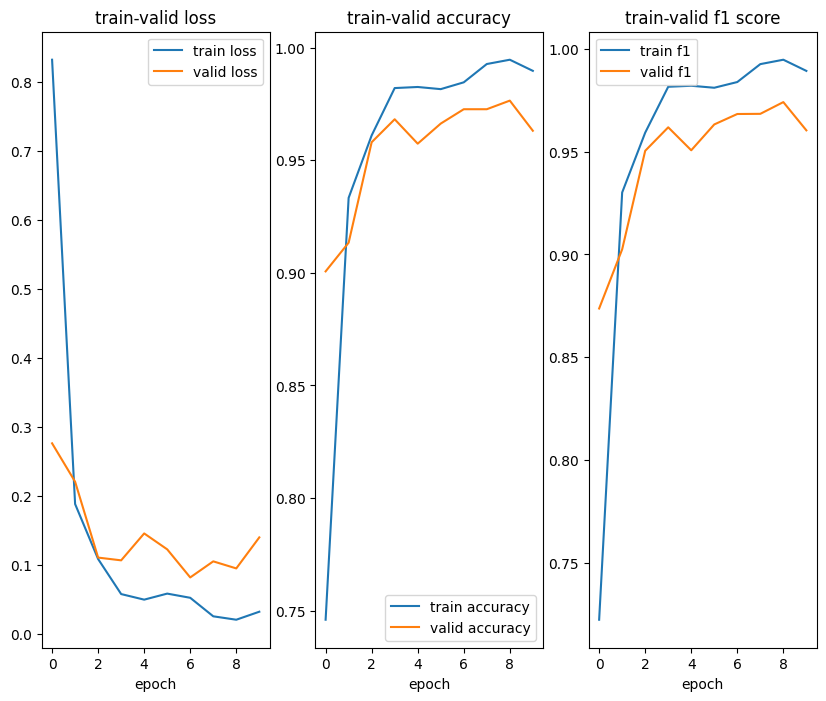

In [65]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, 3, figsize=(10, 8))

# Original Image
axs[0].plot(train_losses, label='train loss')
axs[0].plot(valid_losses, label='valid loss')
axs[0].set_title('train-valid loss')
axs[0].set_xlabel("epoch")
axs[0].legend()

# Transformed Image
axs[1].plot(train_accuracies, label='train accuracy')
axs[1].plot(valid_accuracies, label='valid accuracy')
axs[1].set_title('train-valid accuracy')
axs[1].set_xlabel("epoch")
axs[1].legend()

axs[2].plot(train_f1, label='train f1')
axs[2].plot(valid_f1, label='valid f1')
axs[2].set_title('train-valid f1 score')
axs[2].set_xlabel("epoch")
axs[2].legend()


plt.show()

In [70]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [71]:
train_dataset = ImageDataset(
    "/data/ephemeral/home/data/train_augmented.csv",
    "/data/ephemeral/home/data/train/",
    transform=trn_transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

In [72]:
train_losses, train_accuracies, train_f1 = [], [], []

for epoch in range(9):
    train_ret = train_one_epoch(train_loader, model, optimizer, loss_fn, device=device)

    train_ret['epoch'] = epoch
    train_losses.append(train_ret['train_loss'])
    train_accuracies.append(train_ret['train_acc'])
    train_f1.append(train_ret['train_f1'])

    print('-' * 20)

    log = ""
    for k, v in train_ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)


Loss: 0.2089: 100%|██████████| 246/246 [00:38<00:00,  6.35it/s]


--------------------
train_loss: 0.7208
train_acc: 0.7775
train_f1: 0.7605
epoch: 0.0000



Loss: 0.5033: 100%|██████████| 246/246 [00:38<00:00,  6.43it/s]


--------------------
train_loss: 0.1575
train_acc: 0.9443
train_f1: 0.9405
epoch: 1.0000



Loss: 0.0259: 100%|██████████| 246/246 [00:38<00:00,  6.44it/s]


--------------------
train_loss: 0.0876
train_acc: 0.9683
train_f1: 0.9666
epoch: 2.0000



Loss: 0.7636: 100%|██████████| 246/246 [00:38<00:00,  6.36it/s]


--------------------
train_loss: 0.0662
train_acc: 0.9806
train_f1: 0.9803
epoch: 3.0000



Loss: 0.0080: 100%|██████████| 246/246 [00:38<00:00,  6.37it/s]


--------------------
train_loss: 0.0440
train_acc: 0.9851
train_f1: 0.9847
epoch: 4.0000



Loss: 0.0629: 100%|██████████| 246/246 [00:38<00:00,  6.34it/s]


--------------------
train_loss: 0.0450
train_acc: 0.9850
train_f1: 0.9830
epoch: 5.0000



Loss: 0.1729: 100%|██████████| 246/246 [00:38<00:00,  6.40it/s]


--------------------
train_loss: 0.0356
train_acc: 0.9897
train_f1: 0.9893
epoch: 6.0000



Loss: 0.0596: 100%|██████████| 246/246 [00:38<00:00,  6.37it/s]


--------------------
train_loss: 0.0187
train_acc: 0.9941
train_f1: 0.9937
epoch: 7.0000



Loss: 0.0028: 100%|██████████| 246/246 [00:38<00:00,  6.41it/s]

--------------------
train_loss: 0.0105
train_acc: 0.9976
train_f1: 0.9975
epoch: 8.0000



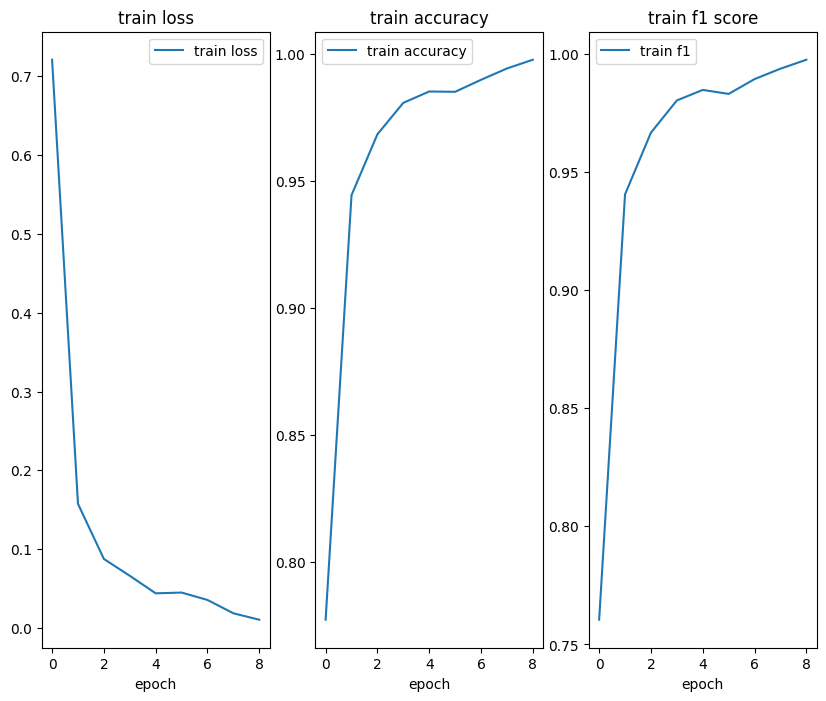

In [73]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, 3, figsize=(10, 8))

# Original Image
axs[0].plot(train_losses, label='train loss')
axs[0].set_title('train loss')
axs[0].set_xlabel("epoch")
axs[0].legend()

# Transformed Image
axs[1].plot(train_accuracies, label='train accuracy')
axs[1].set_title('train accuracy')
axs[1].set_xlabel("epoch")
axs[1].legend()

axs[2].plot(train_f1, label='train f1')
axs[2].set_title('train f1 score')
axs[2].set_xlabel("epoch")
axs[2].legend()


plt.show()

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [74]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:13<00:00,  7.52it/s]


In [75]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [76]:
pred_df

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2
...,...,...
3135,ffb4b6f619fb60ea.jpg,6
3136,ffb54299b1ad4159.jpg,11
3137,ffc2c91dff8cf2c0.jpg,8
3138,ffc4e330a5353a2a.jpg,0


In [77]:
sample_submission_df = pd.read_csv("/data/ephemeral/home/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [78]:
pred_df.to_csv("/data/ephemeral/home/submission/resnet_augmentation_pred_v0.csv", index=False)

In [79]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2
